We will consider the task of deblurring a 1 dimensional signal. To do this we will use discrete 1D convolutions, denoting this operation as $\beta$. Specifically, we will use circular convolutions implemented uing the Fast Fourier Transform and its inverse.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.fft import rfft, irfft
import cvxpy as cvp

We assume that we have some signal $x$ that has been corrupted by some form of blurring and noise such that $y=\beta(x) + z$ for some $z\sim \mathcal{N}(0,\sigma^2)$.

In [2]:
#Setting up filter and signal
N = 100
i = np.arange(0,N)

#Initial signal
sig = np.zeros(100)
sig[9], sig[12], sig[49], sig[69] = 1, -1, 0.3, -0.2
sig = sig.reshape((100,1))

#Noise
s = 0.02 #Standard deviation
rng = np.random.default_rng(123)
z = rng.normal(0, s, 100)
z = z.reshape((100,1))

To estimate the true value of $x$ hidden beneath the blurred and noisy signal we will use the following model:

$$ \hat{x}=arg\min_x||x||_1,\:s.t.\:||\beta(x)-y||_2\leq\epsilon $$

Where $\epsilon=\sigma\sqrt{N}$, with $\sigma$ being the standard deviation of the Gaussian noise.

## Problem 1

Before we begin trying to optimize, we first need to establish more of a backend for our blurring. First, we define a function $\beta$ that will blur a given input vector, then we define a function that will extract a matrix $B$ such that it performs the same operation as a given linear function.

In [3]:
#Blurring function
#NOTE: x needs to be a matrix or column vector
def beta(x):
    N = x.shape[0]
    h = np.array([[np.exp(-((j-2)**2)/2)] for j in range(5)]) #Filter
    
    T = rfft(x,axis=0)*rfft(h,n=N,axis=0)
    return irfft(T, n=N, axis=0)

In [4]:
#Noisy signal
y = beta(sig)+z

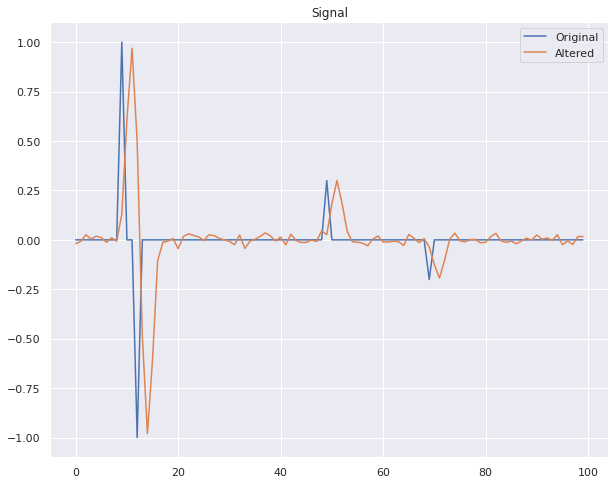

In [5]:
#Plot
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.lineplot(x=i, y=sig[:,0], ax=ax)
sns.lineplot(x=i, y=y[:,0], ax=ax)

ax.set_title('Signal');
ax.legend(['Original', 'Altered']);

In [6]:
#Implicit to explicit
#B_func is linear function, N is input dimensionality
def imp2exp(B_func, N):
    I = np.eye(N)
    return B_func(I)

In [7]:
#Testing our function with a random vector
B = imp2exp(beta, 10)
test = np.random.randn(10).reshape((10,1))
print(np.allclose(B@test, beta(test)))

True


The output above shows that our derived matrix is indeed performing the same operation (within numerical imprecision) as our blurring function. To extract the matrix from the linear function we leverage the fact that $\beta(\mathcal{\mathrm{I}})=B\mathrm{I}$. In other words we can apply our linear function $\beta$ to each elementary vector $e_i$ to extract the corresponding column of $B$.

## Problem 2

We will now solve our minimization problem using the explicit matrix created from our blur function.

In [8]:
B = imp2exp(beta, N)

x1 = cvp.Variable((N,1))
obj = cvp.Minimize(cvp.norm(x1,1))
con = [cvp.norm(B@x1-y) <= s*cvp.sqrt(N)]

prob1 = cvp.Problem(obj, con)

In [9]:
prob1.solve();

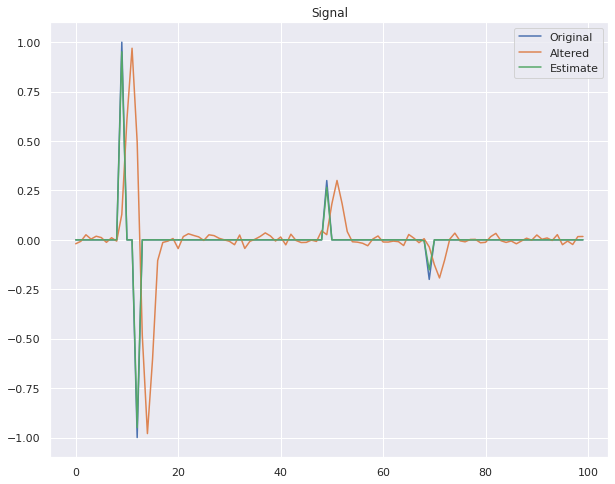

In [10]:
#Plot
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.lineplot(x=i, y=sig[:,0], ax=ax)
sns.lineplot(x=i, y=y[:,0], ax=ax)
sns.lineplot(x=i, y=x1.value[:,0], ax=ax)

ax.set_title('Signal');
ax.legend(['Original', 'Altered', 'Estimate']);

It looks like our estimator $\hat{x}$ is doing a great job, so much so that tt can be hard to tell the difference between the original signal and the esimator. We can see that the only major points of deviation are at the peaks where the estimator seems to be a bit of an under estimate.

## Problem 3

We have solved our problem for $N=100$, but we want to be able to solve it for much larger $N$. To do this we will change our model slightly as follows: find $\lambda$ such that given $y$ and $\epsilon$ the solution can be obtained by solving the following...

$$ \min_x||x||_1+\lambda||Bx-y||_2^2 $$

Below, we alter the constraint of the original problem by squaring both sides, and then we re-solve. This allows us to obtain a dual value ($\lambda$) which we can use in our new formulation.

In [11]:
con = [cvp.sum_squares(B@x1-y) <= N*s**2]
p = cvp.Problem(obj, con)
p.solve()
l = con[0].dual_value

Next, we solve the reformulated minimization problem using our dual value.

In [12]:
x2 = cvp.Variable((N,1))
obj2 = cvp.Minimize(cvp.norm(x2,1) + l*cvp.sum_squares(B@x2-y))
prob2 = cvp.Problem(obj2)

In [13]:
prob2.solve();

In [14]:
print('Soluion absolute error: ', np.linalg.norm(x1.value-x2.value))

Soluion absolute error:  2.761221885458049e-05


We can see that the resulting solutions aren't exactly the same, but they are within a good number of digits.

## Problem 4

We again rewrite our model in the following manner:

$$ \min_x\tau||x||_1+\frac{1}{2}||\beta x-y||_2^2,\: \tau=\frac{1}{2\lambda}$$

This will help us by eliminating the need for an explicit matrix, but before we can use it we need to determine $\nabla f(x)$, where $f$ is the second term in the minimization above.

$$ \nabla f(x) = \nabla(\frac{1}{2}||\beta x-y||_2^2) = \beta^*(\beta(x)-y) $$

With this we will need to write a function that can find the adjoint operator $\beta^*$. To do this we note that we can first write our circular convolution blurring function seen above in the following way:

$$ \beta = \mathcal{F}^{-1}\cdot\mathcal{H}\cdot\mathcal{F} $$

Here, $\mathcal{F}$ is the Fast Fourier Transform and $\mathcal{H}$ is an element wise multiplication operator with the Fourier transformed filter. This gives the form of the adjoint as...

$$ \beta^* = \mathcal{F}^{-1}\cdot\mathcal{H}^*\cdot\mathcal{F} $$

In [15]:
#Blurring adjoint
#Note x needs to be a matrix or column vector
def beta_adj(x):
    N = x.shape[0]
    h = np.array([[np.exp(-((j-2)**2)/2)] for j in range(5)]) #Filter
    
    T = rfft(x,axis=0)*np.conj(rfft(h,n=N,axis=0))
    return irfft(T, n=N, axis=0)

To test whether our adjoint operator is indeed performing as expected we have written a program below that will construct the explicit matrices for both and check that they are adjoints.

In [16]:
def test_adjoint(reg, adj, N=10):
    B = imp2exp(reg, 10)
    B_adj = imp2exp(adj, 10)
    
    return np.allclose(B, np.conj(B_adj.T))

In [17]:
print('Confirm adjoint correct: ', test_adjoint(beta, beta_adj))

Confirm adjoint correct:  True


We can see that our adjoint operator is working as expected.

## Problem 5

We will use a first-order $\ell_1$ solver (in the form of PyUNLocBoX) and our original method using cvxpy.

In [18]:
from pyunlocbox import functions, solvers

t = 1/(2*l)

We start with the first-order method.

In [19]:
f1 = functions.norm_l1(lambda_=t)

f2 = functions.norm_l2(y=y, lambda_=0.5)
f2.A = lambda x: beta(x)
f2.At = lambda x: beta_adj(x)

In [20]:
B = imp2exp(beta, N)
B_ = imp2exp(beta_adj, N)

step = 1/(2*max(np.linalg.eigvalsh(B_@B)))

In [21]:
solver = solvers.forward_backward(step=step)
x0 = np.zeros((N,1))

In [34]:
ret = solvers.solve([f1,f2], x0, solver, rtol=1e-15, verbosity='NONE')['sol']

Now lets solve the same problem using cvxpy.

In [23]:
B = imp2exp(beta, N)

x3 = cvp.Variable((N,1))
obj = cvp.Minimize(t*cvp.norm(x3,1)+0.5*cvp.sum_squares(B@x3-y))

prob3 = cvp.Problem(obj)

In [24]:
prob3.solve();

Great, both methods appear to have worked so lets compare the answers.

In [35]:
print(np.allclose(x3.value, ret))

True


Well thats not great, but on looking at the actual values it seems that it isn't as bad as one might think, lets also look at the norm.

In [36]:
print(np.linalg.norm(x3.value-ret))

2.3153680128926465e-08


In [27]:
print('First order:\n{}\n'.format(ret[0:10]))
print('Standard:\n{}'.format(x3.value[0:10]))

First order:
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.97026259]]

Standard:
[[3.65148660e-20]
 [4.45404560e-20]
 [4.48571470e-20]
 [3.79479332e-20]
 [2.83944282e-20]
 [2.04451152e-20]
 [1.46835217e-20]
 [9.52437497e-21]
 [3.98774713e-21]
 [9.51672565e-01]]


In the output above one can see the first 10 values for both solutions. We see that really they are almost the same, but that the first-order method is doing much better.

In [31]:
ret

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.95167253],
       [ 0.        ],
       [ 0.        ],
       [-0.94995574],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [29]:
print(x3.value)

[[ 3.65148660e-20]
 [ 4.45404560e-20]
 [ 4.48571470e-20]
 [ 3.79479332e-20]
 [ 2.83944282e-20]
 [ 2.04451152e-20]
 [ 1.46835217e-20]
 [ 9.52437497e-21]
 [ 3.98774713e-21]
 [ 9.51672565e-01]
 [-6.36756389e-22]
 [ 1.91141303e-22]
 [-9.49955776e-01]
 [-3.18659602e-21]
 [-9.46835372e-21]
 [-1.68384225e-20]
 [-2.03596386e-20]
 [-1.49338451e-20]
 [ 3.10400819e-21]
 [ 3.19677906e-20]
 [ 6.10634114e-20]
 [ 8.01878097e-20]
 [ 8.72079644e-20]
 [ 8.58307760e-20]
 [ 7.83268448e-20]
 [ 6.33545008e-20]
 [ 4.01422345e-20]
 [ 1.26845044e-20]
 [-1.28521267e-20]
 [-3.06271495e-20]
 [-3.75549903e-20]
 [-3.16043585e-20]
 [-1.04913599e-20]
 [ 2.07867146e-20]
 [ 5.05641066e-20]
 [ 6.71302510e-20]
 [ 6.61683492e-20]
 [ 5.21944909e-20]
 [ 3.42793532e-20]
 [ 1.82222086e-20]
 [ 5.42346590e-21]
 [-5.55851675e-21]
 [-1.18683786e-20]
 [-8.92892644e-21]
 [ 3.60970096e-21]
 [ 1.98338307e-20]
 [ 2.96356623e-20]
 [ 2.64914600e-20]
 [ 1.38994977e-20]
 [ 2.65940545e-01]
 [-1.08196343e-20]
 [-2.15957910e-20]
 [-3.5269023